# Fastweb Assignment 
## Author: Carlo Ghiglione

### Import libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

C:\Users\carlo\AppData\Local\Temp\ipykernel_14732\3168505073.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Load data

In [2]:
# dataset directory
data_dir = os.path.join(os.getcwd(), 'data', 'bank-dataset.csv')

# load data
df = pd.read_csv(data_dir)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261.0,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151.0,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76.0,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92.0,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,unknown,5,may,198.0,1,-1,0,unknown,no


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# Step 1: Data Preprocessing

### Dataset basic information

In [3]:
# size of the dataset
N = df.shape[0]
d = df.shape[1]-1

# numerical variables
col_num = df.select_dtypes(include=[np.number]).columns

# categorical variables
col_cat = df.select_dtypes(exclude=[np.number]).columns

print(f'Dataset size | N: {N} | d: {d}')
print(f'Numerical variables: {col_num.values}')
print(f'Categorical variables: {col_cat.values}')

Dataset size | N: 43097 | d: 16
Numerical variables: ['age' 'balance' 'day' 'duration' 'campaign' 'pdays' 'previous']
Categorical variables: ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome' 'y']


### Correct wrong entries
I see 'marital' variable has some wrong entries (whose correct value is evident), I correct them manually.

In [4]:
for col in col_cat:
    print('-------')
    print(f'{col}')
    print(df[col].value_counts())

# correct wrong entries
df['marital'][df['marital']=='Singl'] = 'single'
df['marital'][df['marital']=='divrcd'] = 'divorced'
df['marital'][df['marital']=='S'] = 'single'
df['marital'][df['marital']=='Single'] = 'single'

-------
job
blue-collar      9448
management       8939
technician       7251
admin.           4927
services         3997
retired          2065
self-employed    1512
entrepreneur     1430
unemployed       1211
housemaid        1193
student           845
unknown           279
Name: job, dtype: int64
-------
marital
married     26102
single      11887
divorced     4940
Singl         100
S              39
divrcd         28
Single          1
Name: marital, dtype: int64
-------
education
secondary    22242
tertiary     12495
primary       6605
unknown       1755
Name: education, dtype: int64
-------
default
no     42298
yes      799
Name: default, dtype: int64
-------
housing
yes    24336
no     18761
Name: housing, dtype: int64
-------
loan
no     36039
yes     7058
Name: loan, dtype: int64
-------
contact
cellular     27574
unknown      12719
telephone     2746
Name: contact, dtype: int64
-------
month
may    13386
jul     6650
aug     5993
jun     5106
nov     3816
apr     2702
feb     2

### NANs for numerical variables

% of NANs in numerical variables
duration    0.001763
age         0.000534
balance     0.000000
day         0.000000
campaign    0.000000
pdays       0.000000
previous    0.000000
dtype: float64


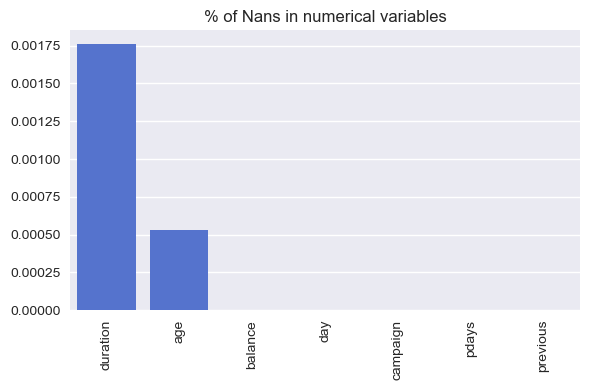

In [5]:
# percentage of NANs for numerical variables
num_nan = df[col_num].isnull().sum()/N
num_nan = num_nan.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=num_nan.index, y=num_nan.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in numerical variables')
fig.tight_layout()

print('% of NANs in numerical variables')
print(num_nan)

### NANs for categorical variables

% of NANs in categorical variables
contact      0.001346
poutcome     0.000232
job          0.000000
marital      0.000000
education    0.000000
default      0.000000
housing      0.000000
loan         0.000000
month        0.000000
y            0.000000
dtype: float64


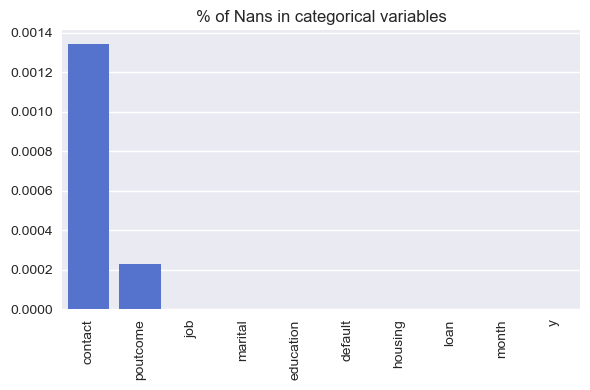

In [6]:
# percentage of NANs for categorical vaiables
cat_nan = df[col_cat].isnull().sum()/N
cat_nan = cat_nan.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=cat_nan.index, y=cat_nan.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in categorical variables')
fig.tight_layout()

print('% of NANs in categorical variables')
print(cat_nan)

### NANs processing
For each variable, I fill the nan values with the mean of the variable for numerical ones and the mode for the categorical ones. The percentage of nan is very low and only 4 variables out of 16 have nans, so I do not introduce a large bias. 

Another possibility would be to remove them, but I should pay attention not to alter significantly the distribution of the target class.

In [7]:
# fill nans with the mean value
for col in col_num:
    df[col] = df[col].fillna(df[col].mean())
    
# fill nans with the mode value
for col in col_cat:
    df[col] = df[col].fillna(df[col].mode()[0])

### Percentage of "unknown" in categorical variables
I see 'poutcome' variable has a large percentage of 'unknown' (more tham 80%). Nevertheless, I keep it since the few non 'unknown' variables may be useful to predict the target.

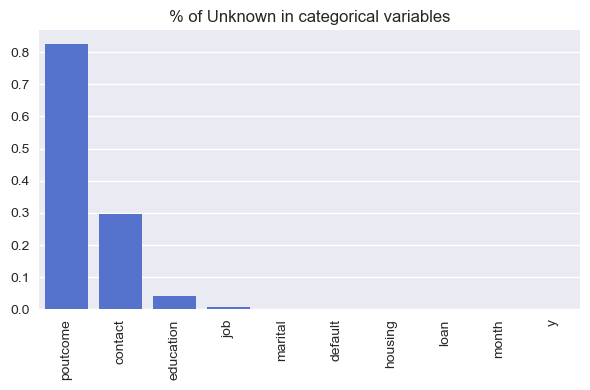

In [8]:
# percentage of "unknown" in categorical variables
cat_ukn = df[col_cat].apply(lambda x: np.sum(x == 'unknown'))/N
cat_ukn = cat_ukn.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=cat_ukn.index, y=cat_ukn.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Unknown in categorical variables')
fig.tight_layout()

### New variable: "season"
I create this new variable telling the season of the last contact aggregating day and month coherently. I do this hoping to help the model to find seasonal trends at a coarser level than month level.

In [9]:
# function to compute the season
def season(df_row):
    day = df_row['day']
    month = df_row['month']
    if (month in ['jan', 'feb']) or (month == 'dec' and day >= 21) or (month == 'mar' and day < 21):
        return 'winter'
    elif (month in ['apr', 'may']) or (month == 'mar' and day >= 21) or (month == 'jun' and day < 21):
        return 'spring'
    elif (month in ['jul', 'aug']) or (month == 'jun' and day >= 21) or (month == 'sep' and day < 23):
        return 'summer'
    else:
        return 'autumn'

df['season'] = df[['day', 'month']].apply(season, axis=1)
col_cat = df.select_dtypes(exclude=[np.number]).columns
col_cat = col_cat[col_cat != 'y']

### Transform "pdays" variable
This variable is not really numerical but it is mixed, since it assumes -1 if the client was not contacted before and a number if it was contacted before telling the number of days passed from the last contact. 

Ideally, -1 would correspond to "infinite" number of days from the last contact, so to make this variable purely numerical I can replace -1 with 0 and the remaining values with their inverse. In this way, for long time passed from the last contact, the pdays variable tends to zero.

In [10]:
new_pdays = np.zeros(N)
new_pdays[df['pdays'] != -1] = 1/(df['pdays'][df['pdays'] != -1])
df['pdays'] = new_pdays

### One-hot encoding of categorical variables

In [11]:
yy_yes_no = df['y']
yy = np.array([1 if x == 'yes' else 0 for x in yy_yes_no])

XX = pd.get_dummies(df.drop(columns=['y']))

### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# Step 2: Preliminary analysis

### Target study
I see the dataset is very unbalanced towards "no" values of the target, only 7% of the target is "yes".
I will have to take this fact into account when developing the model.

Target distribution
no     0.926399
yes    0.073601
Name: y, dtype: float64


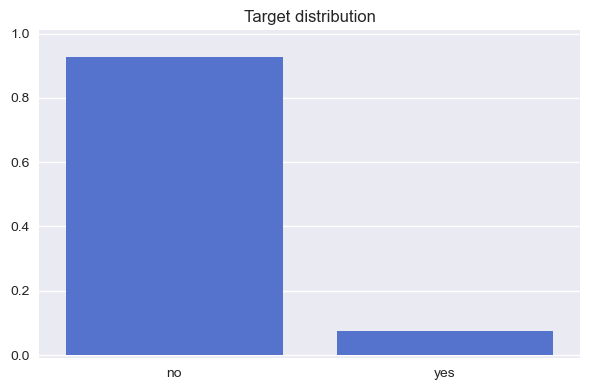

In [12]:
# distribution
yy_distr = yy_yes_no.value_counts()/N

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=yy_distr.index, y=yy_distr.values, color='royalblue', ax=ax)
ax.set_ylim((-0.01, 1.01))
ax.set_title('Target distribution')
fig.tight_layout()

print('Target distribution')
print(yy_distr)

## Visual analysis of categorical variables
I inspect the distribution of each categorical variable with respect to the target.
I see the following variables may have an impact:
1. "job": (retired, student) values may be associated to higher proportion of 'yes' target;
2. "housing": 'no' values may be associated to higher proportion of 'yes' target;
3. "month": (december, march, october, september) may be associated to higher proportion of 'yes' target;
4. "poutcome": 'success' values may be associated to higher proportion of 'yes' target.

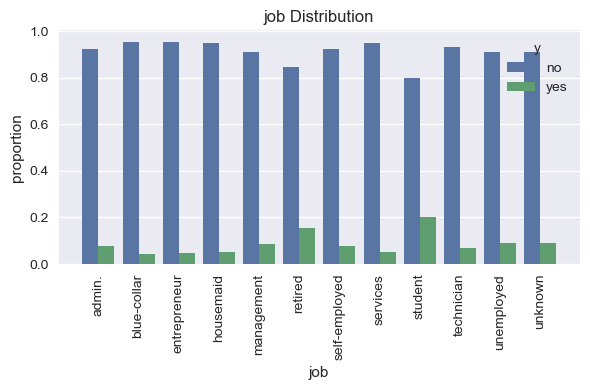

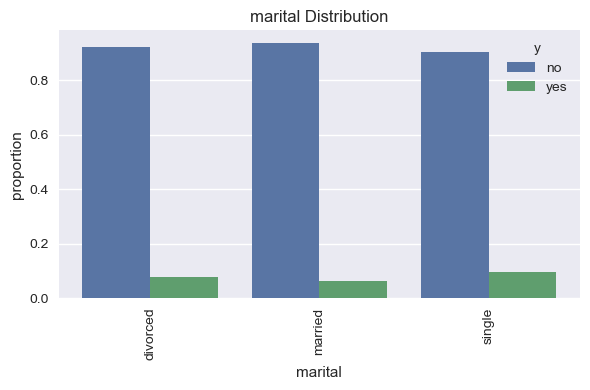

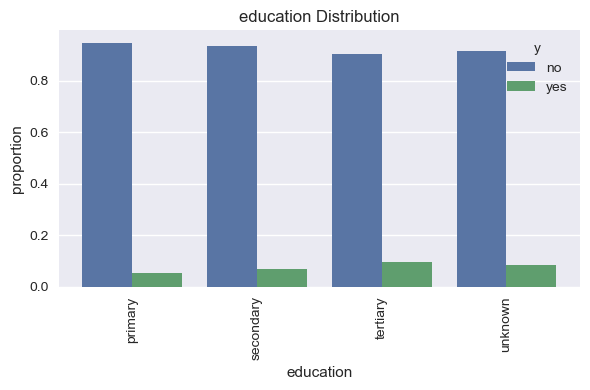

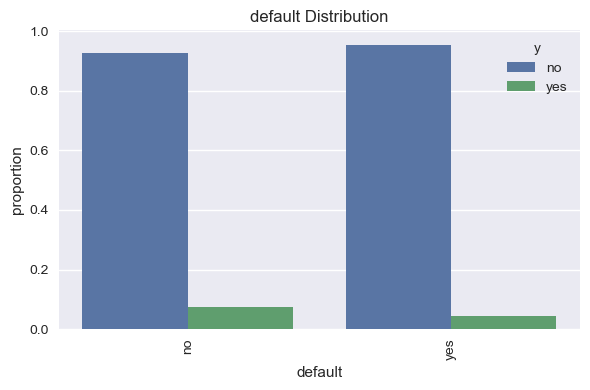

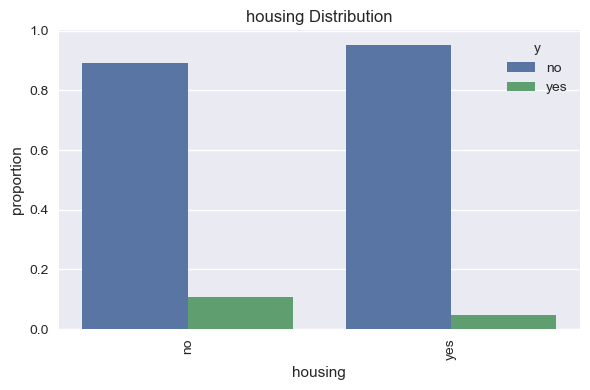

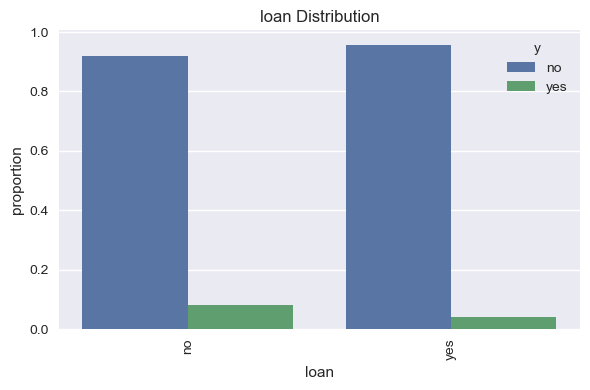

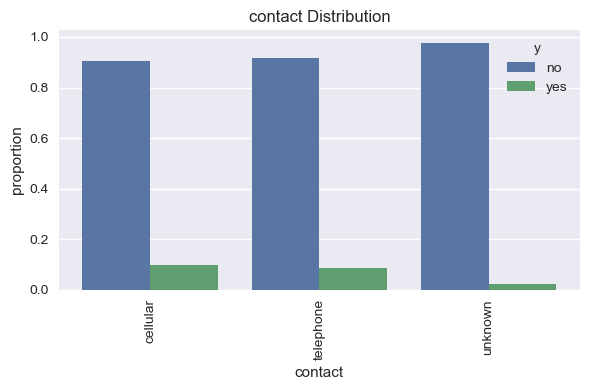

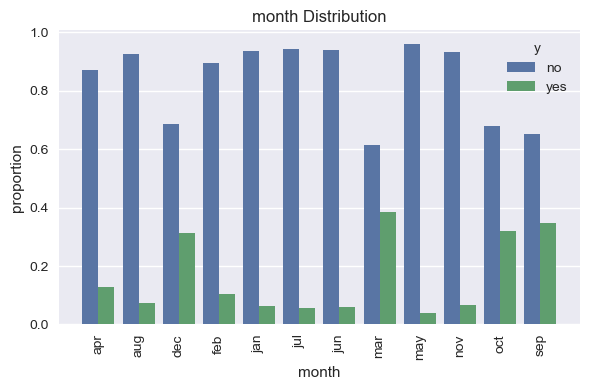

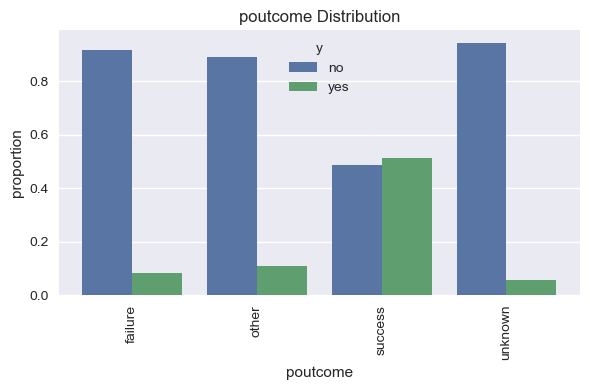

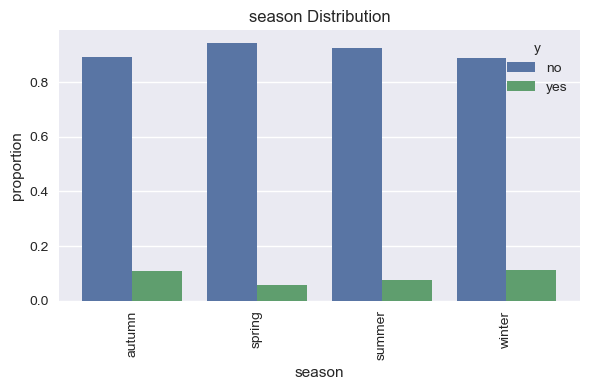

In [13]:
# display the plots for each categorical variable
for col in col_cat:
    
    var = df[[col, 'y']]
    var_distr = var.groupby(col).value_counts(normalize=True).reset_index()
    var_distr.columns = [col, 'y', 'proportion']
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    sns.barplot(data=var_distr, x=col, y='proportion', hue='y')
    ax.set_title(f'{col} Distribution')
    plt.xticks(rotation=90)
    fig.tight_layout()
    plt.plot()

## Visual analysis of numerical variables
I inspect the distribution of each numerical variable with respect to the target.
I see the following variables may have an impact:
1. "balance": higher values may be associated to higher proprortion of 'yes' variable;
2. "duration": higher values may be associated to higher proprortion of 'yes' variable;
3. "pdays": may have different distributions with respect to the output;
4. "previous": may have different distributions with respect to the output.

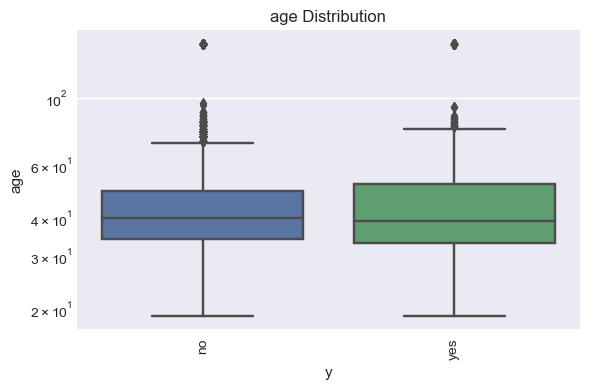

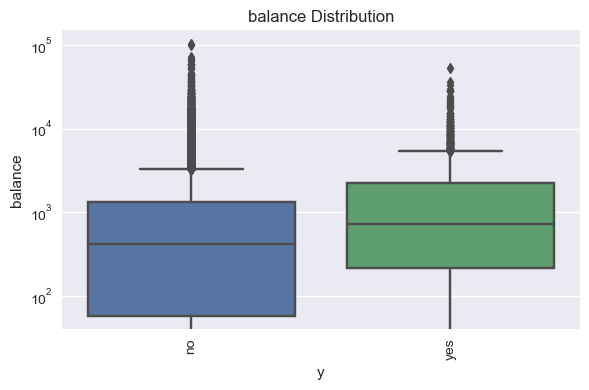

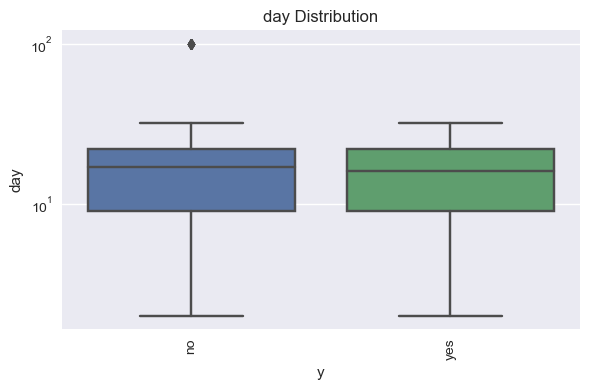

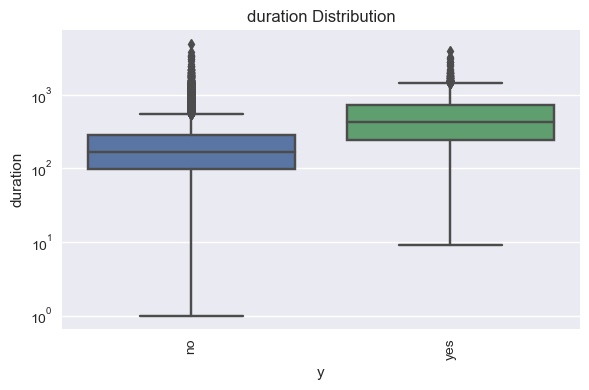

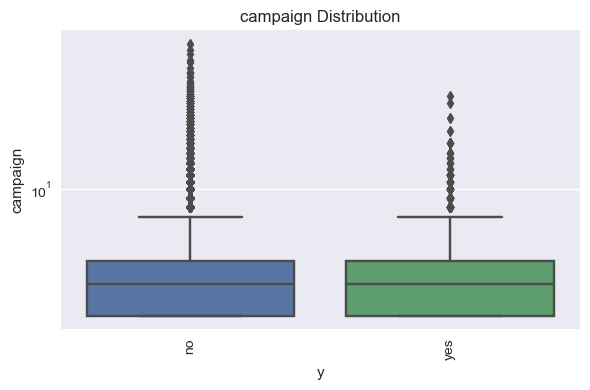

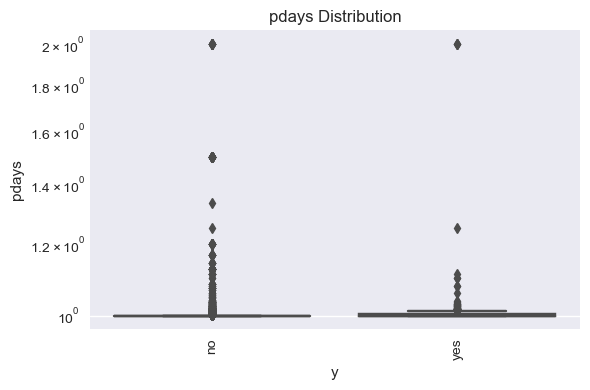

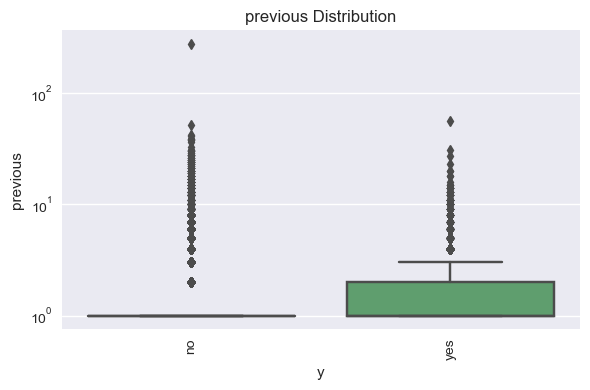

In [14]:
# display the plots for each numerical variable
for col in col_num:

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    sns.boxplot(data=df, x='y', y=df[col]+1)
    ax.set_title(f'{col} Distribution')
    ax.set_yscale('log')
    plt.xticks(rotation=90)
    fig.tight_layout()
    plt.plot()

### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# Step 3: Model development

### Train - Validation - Test Split
I perform train-test split with stratification to preserve the distribution of targets in both datasets. I set the following training split:
- Training set: 80% (for hyperparameter tuning and training of the models)
- Validation set: 10% (for model selection)
- Test set: 10% (for final model evaluation)

In [15]:
# set seed for reproducibility
np.random.seed(1234)

# train validation test split with stratification to preserve the distribution of y in the datasets
X_train, X_else, y_train, y_else = train_test_split(XX, yy, train_size=0.80, shuffle=True, stratify=yy)
X_valid, X_test, y_valid, y_test = train_test_split(X_else, y_else, train_size=0.50, shuffle=True, stratify=y_else)

# K-Fold cross validation object
cv = KFold(n_splits=5)

### Class Imbalance 
To deal with class imbalance of the target, I do:
1. Fit classifiers with weighted classes with weights inversally proportional to the relative frequencies.
2. Evaluate the models with metrics focusing only on the target class of interest ('yes'), that is using Precision, Recall and F1-Score.

Another possibility would be to under-sample or over-sample the dataset to obtain a balanced dataset.

### --------------------------------------------------------------------------------------------------------
## Model 1: Logistic Regression
I perform Logistic Regression with weighted classes using 'l2' regularization. 

The best regularization parameter is searched with cross validation optimizing the F1-Score, finding the best trade-off between Precision and Recall.

In [16]:
# set cross-vaidation
mod1_cv = LogisticRegressionCV(cv=cv, penalty='l2', class_weight='balanced', scoring='f1')

# perform cross-validation
mod1_cv.fit(X_train, y_train)

# best regularization parameter
best_C = mod1_cv.C_[0]

I fit the model with the found parameter, I predict the outcomes for training set and compute the metrics.

In [17]:
# set the model
mod1 = LogisticRegression(C=best_C, penalty='l2', class_weight='balanced')

# fit the model
mod1.fit(X_train, y_train)

# predict the outcome
y_hat_train = mod1.predict(X_train)

# compute the metrics on training set
ris_mod1_train = {
    'Precision': round(precision_score(y_train, y_hat_train), 4),
    'Recall': round(recall_score(y_train, y_hat_train), 4),
    'F1-Score': round(f1_score(y_train, y_hat_train), 4),
    'Accuracy': round(accuracy_score(y_train, y_hat_train), 4)
    }

I evaluate the performances of the model with cross-validation on the training set.

In [18]:
mod1_cv = LogisticRegression(C=best_C, penalty='l2', class_weight='balanced')
cv_ris_mod1 = cross_validate(mod1_cv, X_train, y_train, cv=cv, scoring=['precision', 'recall', 'f1', 'accuracy'])

ris_mod1_cv = {
    'Precision': round(np.mean(cv_ris_mod1['test_precision']), 4),
    'Recall': round(np.mean(cv_ris_mod1['test_recall']), 4),
    'F1-Score': round(np.mean(cv_ris_mod1['test_f1']), 4),
    'Accuracy': round(np.mean(cv_ris_mod1['test_accuracy']), 4)
    }

I visualize the performances of the method. I see the model has high Recall and low Precision, meaning that it tends to have many False Positives. The overall accuracy (indepedently on the class) is quite high.

In [19]:
print('------------------------------')
print('Model 1: Weighted Logistic Regression')
print('----------')
print('Training set results')
print(ris_mod1_train)
print('----------')
print('Cross-validation results')
print(ris_mod1_cv)
print('----------')

------------------------------
Model 1: Weighted Logistic Regression
----------
Training set results
{'Precision': 0.246, 'Recall': 0.8097, 'F1-Score': 0.3774, 'Accuracy': 0.8033}
----------
Cross-validation results
{'Precision': 0.2519, 'Recall': 0.8124, 'F1-Score': 0.3845, 'Accuracy': 0.8086}
----------


### --------------------------------------------------------------------------------------------------------
## Model 2: Random Forest Classifier
I fit a Random Forest Classifier with weighted classes. 

The best combination of 'number of trees' and 'maximum depth' parameters is searched with a grid search with cross validation optimizing the F1-Score, finding the trade-off between Precision and Recall. Since the execution takes some minutes, you can skip it and pass to the next cell where I directly report the results.

In [20]:
"""

# grid of search
param_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20, 30], 'class_weight':['balanced']}

# model
mod2_cv = RandomForestClassifier()

# perform grid search with cross-validation
gs_cv = GridSearchCV(mod2_cv, param_grid, cv=cv, scoring='f1', verbose=3)
gs_cv.fit(X_train, y_train)

# best parameters
best_max_depth = gs_cv.best_params_['max_depth']
best_n_trees = gs_cv.best_params_['n_estimators']

"""

"\n\n# grid of search\nparam_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20, 30], 'class_weight':['balanced']}\n\n# model\nmod2_cv = RandomForestClassifier()\n\n# perform grid search with cross-validation\ngs_cv = GridSearchCV(mod2_cv, param_grid, cv=cv, scoring='f1', verbose=3)\ngs_cv.fit(X_train, y_train)\n\n# best parameters\nbest_max_depth = gs_cv.best_params_['max_depth']\nbest_n_trees = gs_cv.best_params_['n_estimators']\n\n"

I fit the model with the found parameter, I predict the outcomes for training set and compute the metrics.

In [21]:
# best parameters (found in the above cell)
best_max_depth = 15
best_n_trees = 100

# set the model
mod2 = RandomForestClassifier(n_estimators=best_n_trees, max_depth=best_max_depth, class_weight='balanced')

# fit the model
mod2.fit(X_train, y_train)

# predict the outcome
y_hat_train = mod2.predict(X_train)

# compute the metrics on training set
ris_mod2_train = {
    'Precision': round(precision_score(y_train, y_hat_train), 4),
    'Recall': round(recall_score(y_train, y_hat_train), 4),
    'F1-Score': round(f1_score(y_train, y_hat_train), 4),
    'Accuracy': round(accuracy_score(y_train, y_hat_train), 4)
    }

I evaluate the performances of the model with cross-validation on the training set.

In [22]:
mod2_cv = RandomForestClassifier(n_estimators=best_n_trees, max_depth=best_max_depth, class_weight='balanced')
cv_ris_mod2 = cross_validate(mod2_cv, X_train, y_train, cv=cv, scoring=['precision', 'recall', 'f1', 'accuracy'])

ris_mod2_cv = {
    'Precision': round(np.mean(cv_ris_mod2['test_precision']), 4),
    'Recall': round(np.mean(cv_ris_mod2['test_recall']), 4),
    'F1-Score': round(np.mean(cv_ris_mod2['test_f1']), 4),
    'Accuracy': round(np.mean(cv_ris_mod2['test_accuracy']), 4)
    }

I visualize the performances of the model. I see the F1-Score has significanlty increased on training set, meaning that potentially it has an overall better balance between Precision and Recall. Also the global accuracy has increased. I see the performances decrease from the training set to the cross-validation, meaning that there are some overfitting issues. 

In [23]:
print('------------------------------')
print('Model 2: Weighted Random Forest Classifier')
print('----------')
print('Training set results')
print(ris_mod2_train)
print('----------')
print('Cross-validation results')
print(ris_mod2_cv)

------------------------------
Model 2: Weighted Random Forest Classifier
----------
Training set results
{'Precision': 0.6036, 'Recall': 0.9689, 'F1-Score': 0.7438, 'Accuracy': 0.9509}
----------
Cross-validation results
{'Precision': 0.4163, 'Recall': 0.5653, 'F1-Score': 0.4792, 'Accuracy': 0.9096}


### --------------------------------------------------------------------------------------------------------
## Model 3: Gradient Boosting Classifier
I fit a Gradient Boosting Classifier with weighted classes. 

The best combination of 'number of trees' and 'maximum depth' parameters is searched with a grid search with cross validation optimizing the F1-Score, finding the trade-off between Precision and Recall. Since the execution takes a while, you can skip it and pass to the next cell where I directly report the results.

In [24]:
"""
balanced_weights = len(y_train) / (2 * np.bincount(y_train))
sample_weight = [balanced_weights[0] if y == 0 else balanced_weights[1] for y in y_train]

param_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20, 30]}
mod_cv = GradientBoostingClassifier()
gs_cv = GridSearchCV(mod_cv, param_grid, cv=cv, scoring='f1', verbose=3)
gs_cv.fit(X_train, y_train, sample_weight=sample_weight)

best_max_depth = gs_cv.best_params_['max_depth']
best_n_trees = gs_cv.best_params_['n_estimators']
"""

"\nbalanced_weights = len(y_train) / (2 * np.bincount(y_train))\nsample_weight = [balanced_weights[0] if y == 0 else balanced_weights[1] for y in y_train]\n\nparam_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20, 30]}\nmod_cv = GradientBoostingClassifier()\ngs_cv = GridSearchCV(mod_cv, param_grid, cv=cv, scoring='f1', verbose=3)\ngs_cv.fit(X_train, y_train, sample_weight=sample_weight)\n\nbest_max_depth = gs_cv.best_params_['max_depth']\nbest_n_trees = gs_cv.best_params_['n_estimators']\n"

I fit the model with the found parameter, I predict the outcomes for training set and compute the metrics.

In [25]:
# training set weights
balanced_weights = len(y_train) / (2 * np.bincount(y_train))
sample_weight = [balanced_weights[0] if y == 0 else balanced_weights[1] for y in y_train]

# optimal params (coming from previous cell)
best_max_depth = 10
best_n_trees = 100

# set the model
mod3 = GradientBoostingClassifier(n_estimators=best_n_trees, max_depth=best_max_depth)

# fit the model
mod3.fit(X_train, y_train, sample_weight=sample_weight)

# predict the outcome
y_hat_train = mod3.predict(X_train)

# compute the metrics on training set
ris_mod3_train = {
    'Precision': round(precision_score(y_train, y_hat_train), 4),
    'Recall': round(recall_score(y_train, y_hat_train), 4),
    'F1-Score': round(f1_score(y_train, y_hat_train), 4),
    'Accuracy': round(accuracy_score(y_train, y_hat_train), 4)
    }


I evaluate the performances of the model with cross-validation on the training set (it takes 1-2 minutes).

In [26]:
mod3_cv = GradientBoostingClassifier(n_estimators=best_n_trees, max_depth=best_max_depth)
cv_ris_mod3 = cross_validate(mod3_cv, X_train, y_train, cv=cv, scoring=['precision', 'recall', 'f1', 'accuracy'], 
                             fit_params={'sample_weight': sample_weight}, verbose=3)

ris_mod3_cv = {
    'Precision': round(np.mean(cv_ris_mod3['test_precision']), 4),
    'Recall': round(np.mean(cv_ris_mod3['test_recall']), 4),
    'F1-Score': round(np.mean(cv_ris_mod3['test_f1']), 4),
    'Accuracy': round(np.mean(cv_ris_mod3['test_accuracy']), 4)
    }

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  accuracy: (test=0.903) f1: (test=0.459) precision: (test=0.380) recall: (test=0.580) total time=  25.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


[CV] END  accuracy: (test=0.909) f1: (test=0.496) precision: (test=0.422) recall: (test=0.604) total time=  25.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.1s remaining:    0.0s


[CV] END  accuracy: (test=0.912) f1: (test=0.493) precision: (test=0.417) recall: (test=0.603) total time=  24.5s
[CV] END  accuracy: (test=0.908) f1: (test=0.494) precision: (test=0.421) recall: (test=0.599) total time=  25.6s
[CV] END  accuracy: (test=0.914) f1: (test=0.535) precision: (test=0.458) recall: (test=0.642) total time=  25.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


I visualize the performances of the model. I see the performances decrease from the training set to the cross-validation, meaning that there are some overfitting issues also in this case. Also here Recall is higher than Precision.

In [27]:
print('------------------------------')
print('Model 3: Weighted Gradient Boosting')
print('----------')
print('Training set results')
print(ris_mod3_train)
print('----------')
print('Cross-validation results')
print(ris_mod3_cv)

------------------------------
Model 3: Weighted Gradient Boosting
----------
Training set results
{'Precision': 0.7448, 'Recall': 0.9992, 'F1-Score': 0.8534, 'Accuracy': 0.9747}
----------
Cross-validation results
{'Precision': 0.4196, 'Recall': 0.6055, 'F1-Score': 0.4956, 'Accuracy': 0.9093}


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# Step 4: Model selection

I study the generalization performances of the three models in terms of Precision, Recall, F1-Score and Accuracy on the validation set.

In [28]:
mod_list = [mod1, mod2, mod3]

ris_valid_list = []

for i in range(3):
    y_hat_valid = mod_list[i].predict(X_valid)

    ris_valid = {
        'Precision': round(precision_score(y_valid, y_hat_valid), 4),
        'Recall': round(recall_score(y_valid, y_hat_valid), 4),
        'F1-Score': round(f1_score(y_valid, y_hat_valid), 4),
        'Accuracy': round(accuracy_score(y_valid, y_hat_valid), 4)
        }
    ris_valid_list.append(ris_valid)
    

perf_recap_valid = pd.DataFrame(ris_valid_list, index=['mod 1', 'mod 2', 'mod 3'])

print(perf_recap_valid)

       Precision  Recall  F1-Score  Accuracy
mod 1     0.2551  0.8265    0.3899    0.8097
mod 2     0.4289  0.6088    0.5033    0.9116
mod 3     0.4102  0.5836    0.4818    0.9077


I plot the Precision-Recall curve and the Receiver Operating Characteristic curve, computing the Area Under Curve scores on the validation set.

         PR-AUC   ROC-AUC
mod 1  0.360854  0.888757
mod 2  0.456826  0.919909
mod 3  0.443587  0.912082


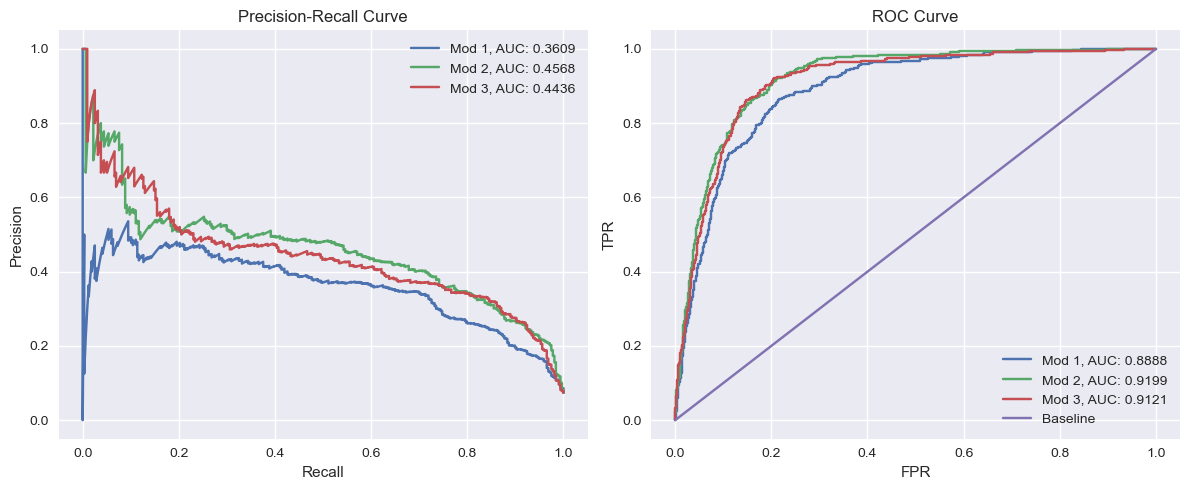

In [29]:
# list of the fitted methods
mod_list = [mod1, mod2, mod3]

pr_auc_list = []
roc_auc_list = []
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(3):

    # predict
    y_hat = mod_list[i].predict(X_valid)
    y_hat_p = mod_list[i].predict_proba(X_valid)
    
    # compute precision, recall for different thresholds
    prec, rec, thresh = precision_recall_curve(y_true=y_valid, probas_pred=y_hat_p[:,1])
    pr_auc = average_precision_score(y_valid, y_hat_p[:,1])
    pr_auc_list.append(pr_auc)
    
    # compute fpr, tpr for different thresholds
    fpr, tpr, thresh = roc_curve(y_true=y_valid, y_score=y_hat_p[:,1])
    roc_auc = roc_auc_score(y_valid, y_hat_p[:,1])
    roc_auc_list.append(roc_auc)
    
    ax[0].plot(rec, prec, label=f'Mod {i+1}, AUC: {round(pr_auc, 4)}')
    ax[1].plot(fpr, tpr, label=f'Mod {i+1}, AUC: {round(roc_auc, 4)}')

ax[0].legend()
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve')

ax[1].plot([0.0,1.0],[0.0,1.0], label='Baseline')
ax[1].legend()
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
ax[1].set_title('ROC Curve')

fig.tight_layout()

df_auc = pd.DataFrame({'PR-AUC': pr_auc_list, 'ROC-AUC': roc_auc_list}, index=['mod 1', 'mod 2', 'mod 3'])

print(df_auc)

I inspect the **Lift** of the models on the validation set.

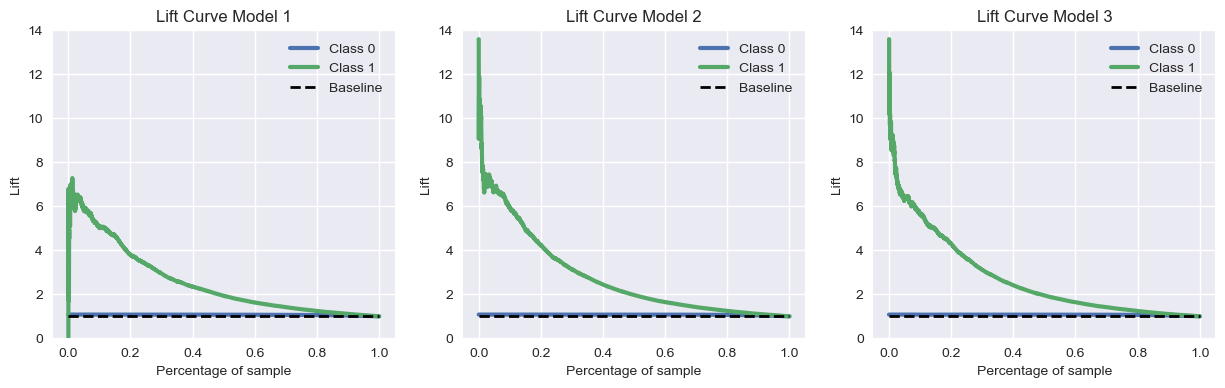

In [30]:
import scikitplot as skplt

mod_list = [mod1, mod2, mod3]

# show the lift curves of the models
fig, ax = plt.subplots(1,3, figsize=(15,4))
for i in range(3):
    y_p = mod_list[i].predict_proba(X_valid)
    skplt.metrics.plot_lift_curve(y_valid, y_p, ax=ax[i], title=f"Lift Curve Model {i+1}")
    ax[i].set_ylim([0,14])
    ax[i].legend(loc="upper right")

In [31]:
# function to compute the lift of a given percentile perc
def compute_lift(y_true, y_p, perc):
    df_y = pd.DataFrame({'y_true':y_true, 'y_p':y_p[:,1]})
    df_y = df_y.sort_values(by='y_p', ascending=False)
    df_y['perc'] = np.ceil(100*(np.arange(1,len(df_y)+1)/len(df_y)))
    conv_rate_perc = df_y['y_true'][df_y['perc']<perc].sum()/len(df_y['y_true'][df_y['perc']<perc])
    conv_rate = df_y['y_true'].sum()/len(df_y['y_true'])
    return conv_rate_perc/conv_rate

# set the percentile I want to compute the lift
perc = 10
lift_perc_list = []
for i in range(3):
    y_p = mod_list[i].predict_proba(X_valid)
    lift_perc_list.append(compute_lift(y_valid, y_p, perc)) 

df_lift_perc = pd.Series(lift_perc_list, index=['mod 1', 'mod 2', 'mod 3'])
print(f"Lift at {perc} percentile")
print(df_lift_perc)


Lift at 10 percentile
mod 1    5.234718
mod 2    6.148159
mod 3    5.831968
dtype: float64


**Model 2** has the best performances in terms of F1 score, AUC Precision-recall, AUC ROC and lift at 10 percentile. I choose it as final model.

### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# Step 5: Model check and final considerations

I test the selected model on the test set left apart.

In [32]:
# final model
mod_final = mod2

y_hat_test= mod_final.predict(X_test)
y_p_test = mod_final.predict_proba(X_test)
perc = 10

ris_test = {
    'Precision': round(precision_score(y_test, y_hat_test), 4),
    'Recall': round(recall_score(y_test, y_hat_test), 4),
    'F1-Score': round(f1_score(y_test, y_hat_test), 4),
    'Accuracy': round(accuracy_score(y_test, y_hat_test), 4),
    f"Lift at {perc} percentile": round(compute_lift(y_test, y_p_test, perc),2)
    }

print('------------------------------')
print('Final Model')
print('----------')
print('Test set results')
print(ris_test)

------------------------------
Final Model
----------
Test set results
{'Precision': 0.4237, 'Recall': 0.6215, 'F1-Score': 0.5038, 'Accuracy': 0.91, 'Lift at 10 percentile': 6.18}


Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

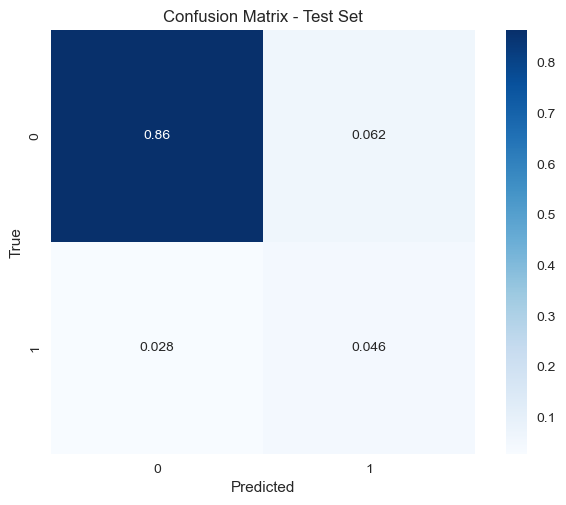

In [33]:
cm = confusion_matrix(y_test, y_hat_test)/len(y_test)

fig, ax = plt.subplots(1,1)
sns.heatmap(cm, cmap='Blues', annot=True, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - Test Set')

I check the most influential variables in the prediction with the 'feature importance' metric of tree based methods.

Text(0.5, 1.0, 'Final Model - Feature Importance')

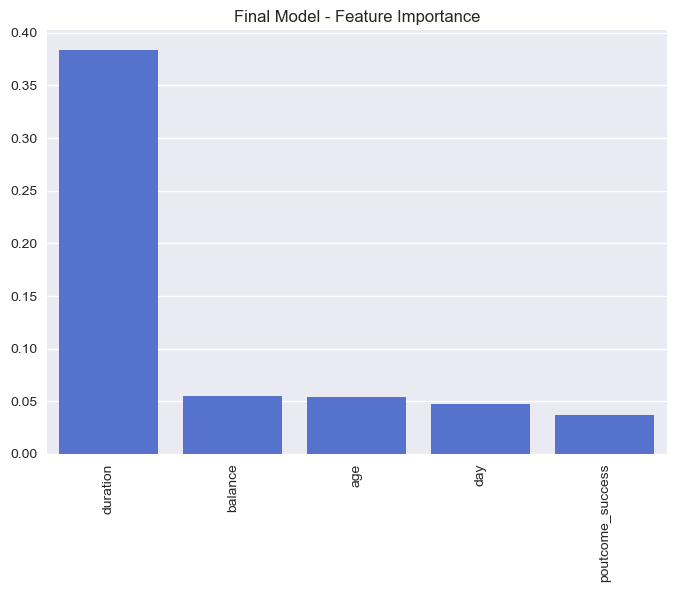

In [34]:
# feature importance
feat_imp = pd.Series(mod_final.feature_importances_, index=XX.columns)
feat_imp = feat_imp.sort_values(ascending=False)

fig, ax = plt.subplots(1,1)
sns.barplot(x=feat_imp[:5].index, y=feat_imp[:5].values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('Final Model - Feature Importance')

### Comments on the final model:
1. The model has **higher Recall than Precision**. This means that it tends to produce many False Positives, as it is visible from the Confusion Matrix. This fact can be adjusted setting different thresholds on the probability above which the model states if an input is positive (the default value is 0.5) depending on the context and on the interest of the experimenter.
2. The model has a **lift of 6** at the test set for the first decile. This means that targeting customers in 1 decile provides a 6 times higher probability to accept the offer with respect to the average. As a consequence the model is good to elaborate campaigns to target customers in higher percentiles of model score.
3. From the feature importance plot some of the preliminary observations done during the visual inspection of the data are confirmed: **the duration of the last contact is the most influential variable** to predict the outcome, together with the success of the outcome of the last marketing campaign and the average yearly balance. Strong relations with "age" and "day" have been found that where not evident from the visual inspection of the data.


### Improvements and future developments
During the development of this model, I have identified the following possible areas of improvement and development:
1. Perform **finer hyper-parameter tuning**: for tree based methods, I have tuned only the number of trees and the maximum depth, but there are other parameters to be tuned. This could benefit the performances of the method and, possibly, reduce overfitting issues.
2. Try with **Neural Networks**: they offer very large flexibility to fit data patterns, they could possibly improve the performances of the method. Nevertheless, in the majority of the cases tree based methods provide equivalent results on tabular data. Indeed, their high flexibility is often source of overfitting issues that I am still having with tree-based methods, so their design should be done carefuly.
3. Try **different strategies to deal with unbalanced classes**: here I have used weighted classes, but other possibilites are under-sampling the larger class or over-sampling the smaller class.
4. **Dataset transformation**: if I better analyse the data and reflect on the meaning of the variables for this specific context, I could introuce more effective variables and delete unuseful ones. Another possiblity could be to segment the dataset from context specific knowledge or with data driven clustering techniques and develop a different model for each group.
5. Better investigate the impact of each feature with **SHAP analysis**.